# **Import Dataset**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from datetime import datetime

In [5]:
# -- Import File --
path = 'dailybrentoil.csv'

df_daily = pd.read_csv(path)
df_daily = df_daily.iloc[:, :-3]
df_daily.head()

,Date,Close,chg(close),Low,chg(low),High,chg(high)
0,1/4/2021 23:58:00,50.23,50.23,49.97,49.97,51.88,51.88
1,1/5/2021 23:58:00,51.87,1.64,50.01,0.04,52.26,0.38
2,1/6/2021 23:58:00,52.02,0.15,51.21,1.20,52.37,0.11
3,1/7/2021 23:58:00,52.20,0.18,51.89,0.68,52.34,-0.03
4,1/8/2021 23:58:00,53.33,1.13,52.31,0.42,53.61,1.27


In [47]:
# -- Membersihkan Outliers --
Q1 = df_daily.quantile(0.25)
Q3 = df_daily.quantile(0.75)
IQR = Q3-Q1
df_daily=df_daily[~((df_daily<(Q1-1.5*IQR))|(df_daily>(Q3+1.5*IQR))).any(axis=1)]

df_daily.shape

<ipython-input-47-5e36f262baef>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_daily.quantile(0.25)
<ipython-input-47-5e36f262baef>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_daily.quantile(0.75)
<ipython-input-47-5e36f262baef>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_daily=df_daily[~((df_daily<(Q1-1.5*IQR))|(df_daily>(Q3+1.5*IQR))).any(axis=1)]


(674, 7)

# **Eksplorasi dan Analisis Dataset**

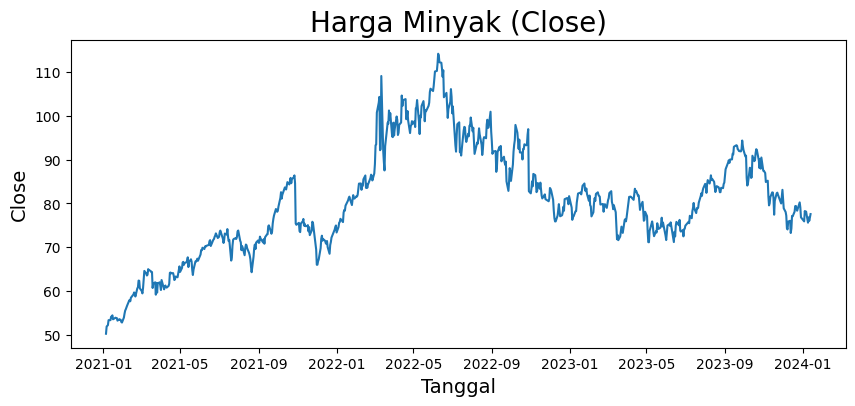

In [6]:
df = df_daily['Close']
df.index = pd.to_datetime(df_daily.Date)
awal = datetime(2021, 1, 4)
akhir = datetime(2024, 12, 1)
df = df[awal:akhir]
df = df.asfreq(freq='D')
df.interpolate(inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(df)
plt.title('Harga Minyak (Close)', fontsize=20)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Close', fontsize=14)
plt.show()

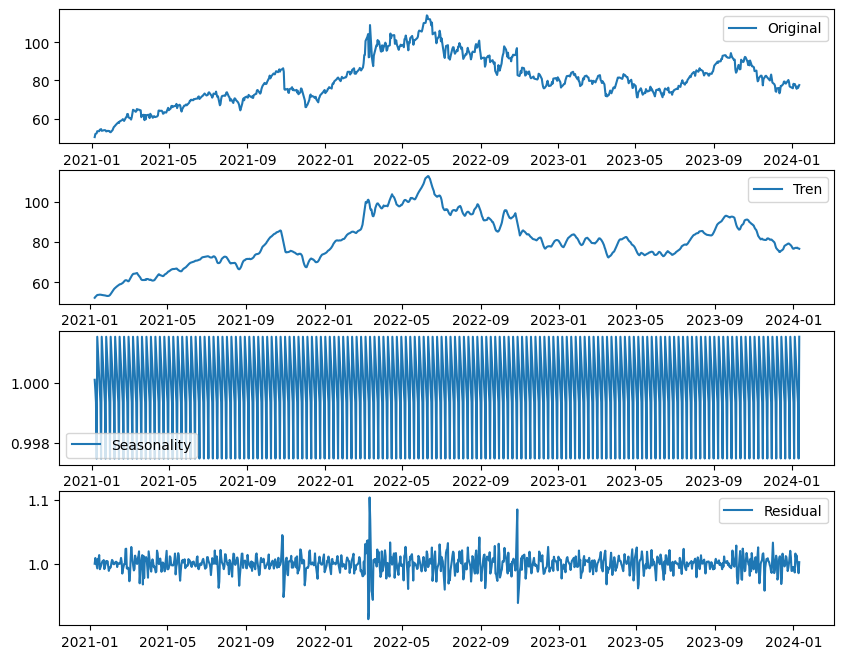

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df, model='multiplicative')
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(df, label='Original')
ax[0].legend(loc='best')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='best')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='best')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='best')
plt.show()

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

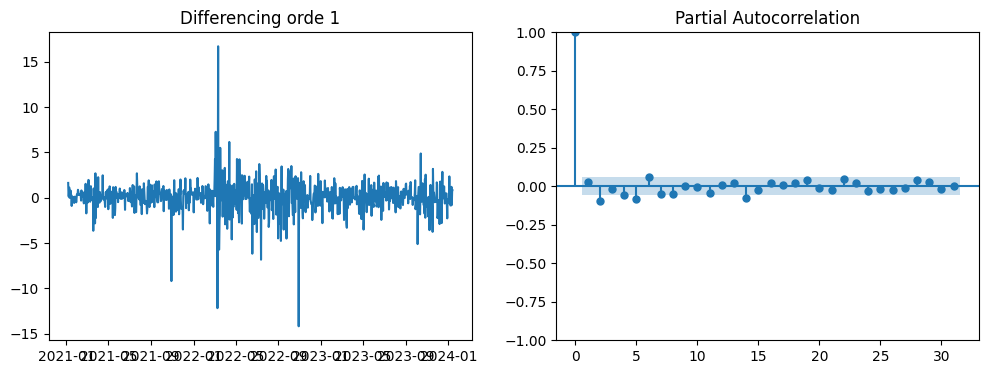

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df.diff())
axes[0].set_title('Differencing orde 1')
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

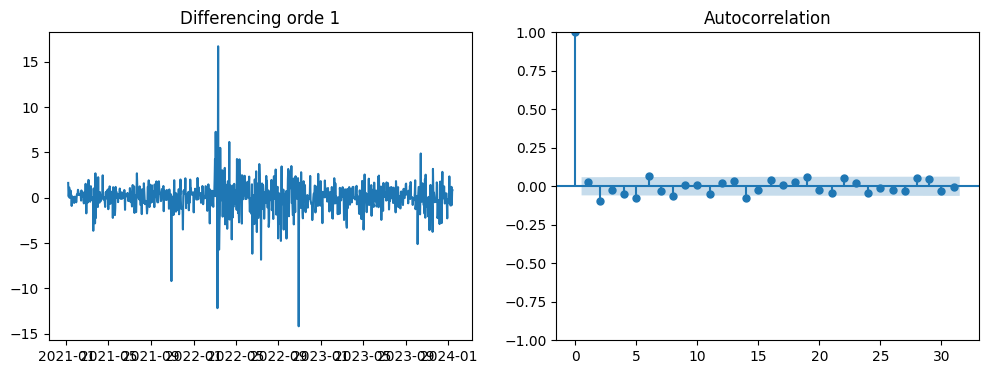

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df.diff())
axes[0].set_title('Differencing orde 1')
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

# **Model ARIMA (Baseline)**

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

df_train = df[:'2023-11-15']
df_test = df['2023-11-16':]

# -- Model ARIMA (1, 1, 1)
model = ARIMA(df_train, order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1046
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1918.034
Date:                Mon, 15 Jan 2024   AIC                           3842.069
Time:                        05:02:21   BIC                           3856.924
Sample:                    01-04-2021   HQIC                          3847.703
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4498      0.189     -2.386      0.017      -0.819      -0.080
ma.L1          0.5044      0.182      2.774      0.006       0.148       0.861
sigma2         2.3002      0.031     73.531      0.000       2.239       2.362
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):             31178.08
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.53
Prob(H) (two-sided):                  0.11   Kurtosis:                        29.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

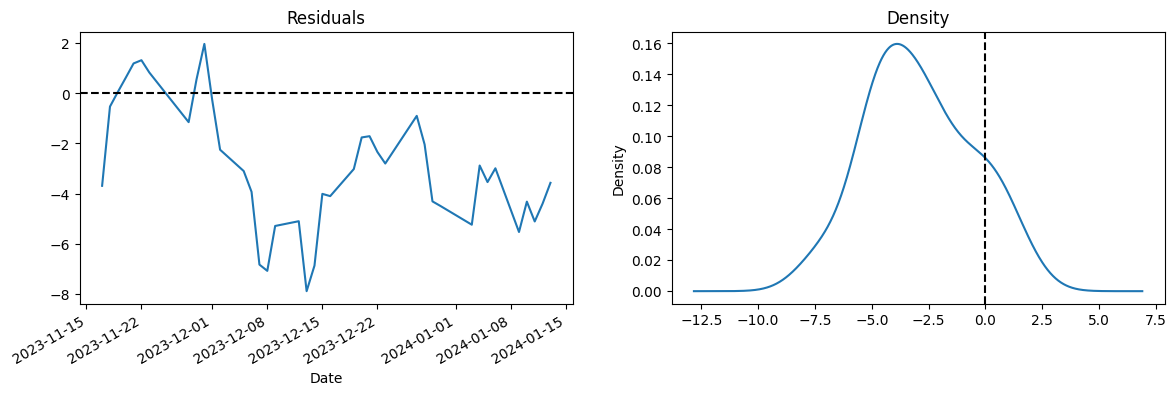

In [12]:
# Plot residual errors
pred = model_fit.predict(df_test.index[0], df_test.index[-1])
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

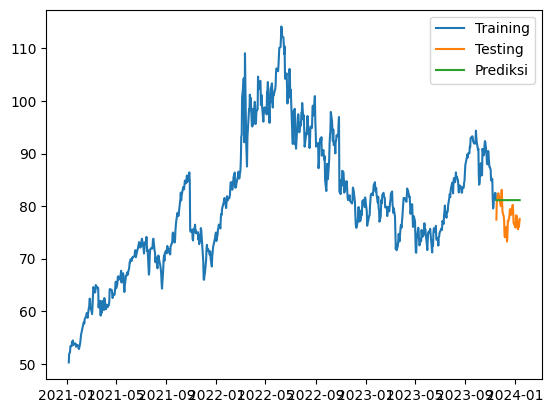

MAPE: 4.1%
RMSE: 3.70941734141014


In [13]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

# **Tuning**

In [14]:
model2 = ARIMA(df_train, order=(1, 0, 1)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1046
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1922.013
Date:                Mon, 15 Jan 2024   AIC                           3852.027
Time:                        05:02:23   BIC                           3871.838
Sample:                    01-04-2021   HQIC                          3859.540
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.0434      5.337     14.435      0.000      66.582      87.504
ar.L1          0.9936      0.003    396.684      0.000       0.989       0.999
ma.L1          0.0413      0.018      2.307      0.021       0.006       0.076
sigma2         2.3000      0.026     87.135      0.000       2.248       2.352
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             33256.27
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.34
Prob(H) (two-sided):                  0.15   Kurtosis:                        30.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

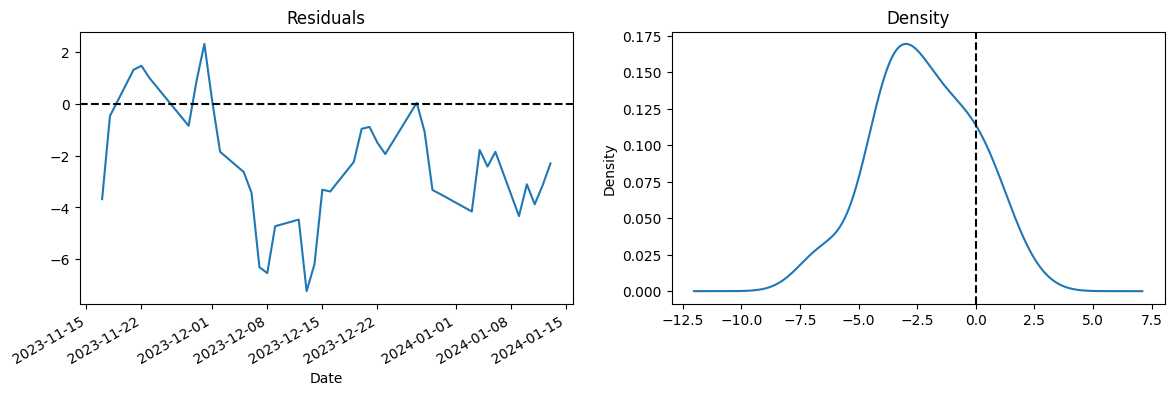

In [15]:
pred = model2.predict(df_test.index[0], df_test.index[-1])
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

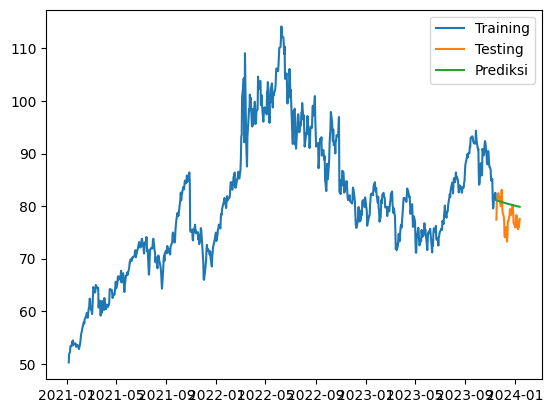

MAPE: 3.3%
RMSE: 3.074345859721573


In [16]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

# **Tuning auto_arima**

In [17]:
import pmdarima as pm

model3 = pm.auto_arima(df_train, start_p=0, start_q=0,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=4, max_q=4,
                       m=1, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=False,
                       start_P=0,
                       D=0,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model3.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3843.565, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3844.614, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3844.408, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3841.962, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3843.698, Time=0.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.702 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1046
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1919.981
Date:                Mon, 15 Jan 2024   AIC                           3841.962
Time:                        05:02:27   BIC                           3846.914
Sample:                    01-04-2021   HQIC                          3843.840
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3088      0.026     87.748      0.000       2.257       2.360
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):             33029.47
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.44
Prob(H) (two-sided):                  0.11   Kurtosis:                        30.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

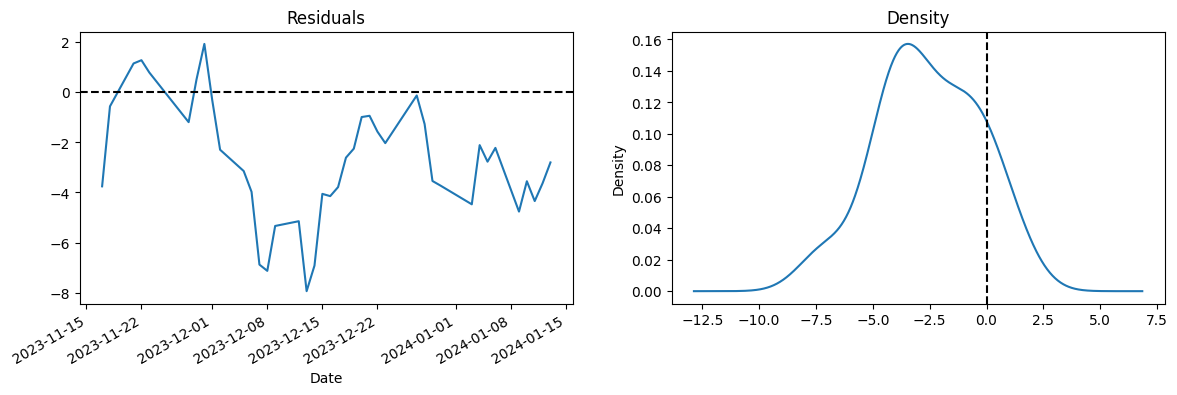

In [18]:
pred = model3.predict(31)
pred = pd.Series(pred, index=df_test.index)
pred.fillna(df.mean(), inplace=True)
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

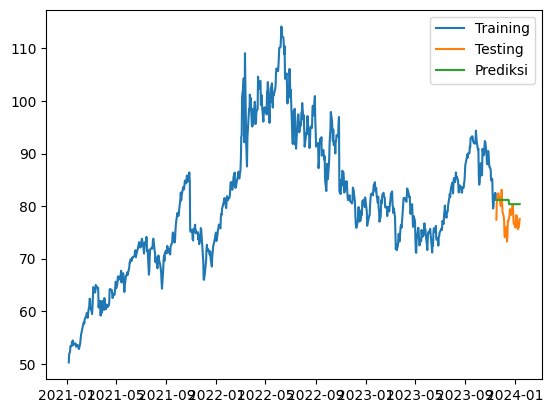

MAPE: 3.66%
RMSE: 3.419949788443793


In [19]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

# **Seasonality pakai SARIMA**

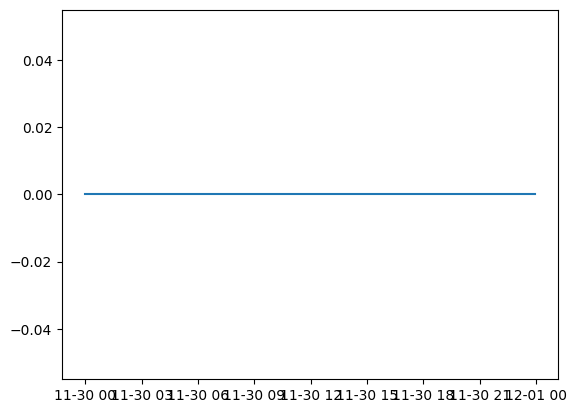

In [34]:
plt.plot(seasonal['2023-11-01':'2023-11-30'].diff(28))
plt.show()

In [35]:
# Memilih subset data terakhir untuk fitting model
df_subset = df_train[-300:]

In [36]:
model4 = pm.auto_arima(df_subset, start_p=1, start_q=1,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=3, max_q=3,
                       m=28, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model4.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[28]             : AIC=inf, Time=3.32 sec
 ARIMA(0,1,0)(0,1,0)[28]             : AIC=987.353, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[28]             : AIC=922.119, Time=0.70 sec
 ARIMA(0,1,1)(0,1,1)[28]             : AIC=inf, Time=2.63 sec
 ARIMA(1,1,0)(0,1,0)[28]             : AIC=984.392, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[28]             : AIC=915.330, Time=3.41 sec
 ARIMA(1,1,0)(2,1,1)[28]             : AIC=inf, Time=13.45 sec
 ARIMA(1,1,0)(1,1,1)[28]             : AIC=inf, Time=7.29 sec
 ARIMA(0,1,0)(2,1,0)[28]             : AIC=916.685, Time=2.36 sec
 ARIMA(2,1,0)(2,1,0)[28]             : AIC=917.289, Time=3.05 sec
 ARIMA(1,1,1)(2,1,0)[28]             : AIC=917.309, Time=4.26 sec
 ARIMA(0,1,1)(2,1,0)[28]             : AIC=915.478, Time=3.46 sec
 ARIMA(2,1,1)(2,1,0)[28]             : AIC=916.534, Time=16.92 sec
 ARIMA(1,1,0)(2,1,0)[28] intercept   : AIC=917.319, Time=8.32 sec

Best model:  ARIMA(1,1,0)(2,1,0)[28]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 28)   Log Likelihood                -453.665
Date:                            Mon, 15 Jan 2024   AIC                            915.330
Time:                                    05:17:37   BIC                            929.738
Sample:                                01-20-2023   HQIC                           921.115
                                     - 11-15-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1112      0.059      1.900      0.057      -0.004       0.226
ar.S.L28      -0.5893      0.059     -9.986      0.000      -0.705      -0.474
ar.S.L56      -0.2140      0.061     -3.526      0.000      -0.333      -0.095
sigma2         1.6043      0.097     16.622      0.000       1.415       1.793
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                56.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.16
Prob(H) (two-sided):                  0.81   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

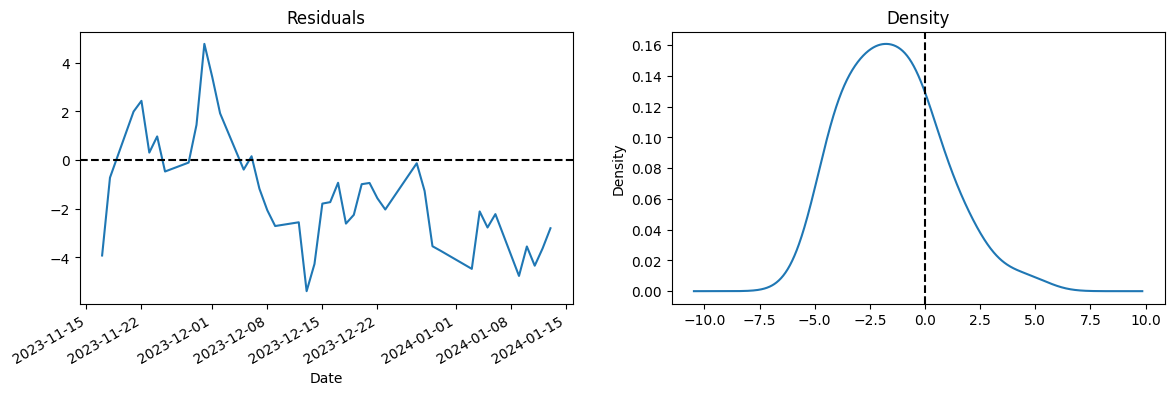

In [37]:
pred = model4.predict(31)
pred = pd.Series(pred, index=df_test.index)
pred.fillna(df.mean(), inplace=True)
residuals = df_test - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

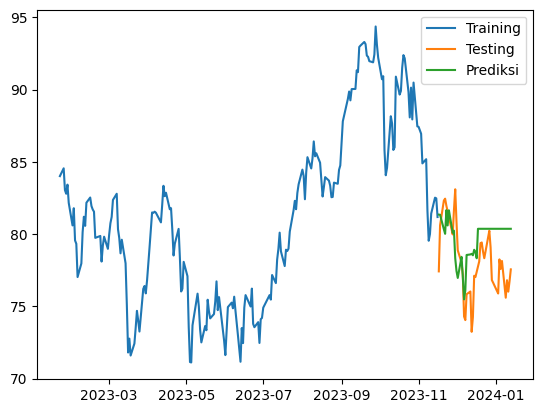

MAPE: 2.82%
RMSE: 2.6217965051629295


In [38]:
plt.plot(df_subset, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred) * 100, 2)))
print('RMSE:', mse(df_test, pred, squared=False))

# **Forecast ARIMA**

In [43]:
pred3 = df_test.copy()

for index in tqdm(df_test.index):
    train_data = df[:index - timedelta(days=1)]

    orderx = (1, 0, 1)
    model2 = ARIMA(train_data, order=orderx).fit()

    pred = model2.forecast()
    pred3[index] = pred

100%|██████████| 58/58 [01:09<00:00,  1.20s/it]


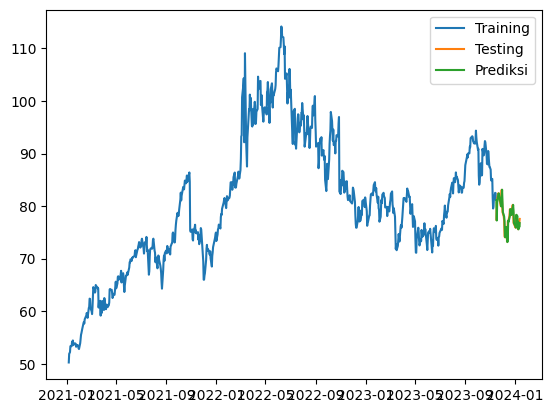

MAPE: 1.13%
RMSE: 1.2525273951439408


In [45]:
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Testing')
plt.plot(pred3, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(df_test, pred3) * 100, 2)))
print('RMSE:', mse(df_test, pred3, squared=False))

# **Prediksi**

<ipython-input-46-2b0d68fbf368>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(df.append(jan)['2024-01-13':], label='Prediksi')
<ipython-input-46-2b0d68fbf368>:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  plt.plot(df.append(jan)['2024-01-13':], label='Prediksi')


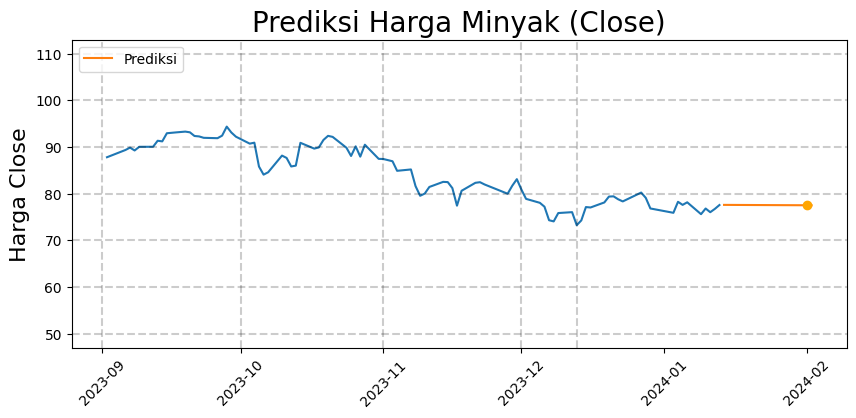

In [46]:
model_final = ARIMA(df, order=(1, 0, 1)).fit()
# Prediksi
jan = model_final.predict('2023-12-13', '2024-02-01')

fig = plt.figure(figsize=(10, 4))
plt.plot(df['2023-09-01':])
plt.plot(df.append(jan)['2024-01-13':], label='Prediksi')
plt.plot(datetime(2024, 2, 1), jan['2024-02-01'], marker='o', color='orange')
plt.xticks(rotation=45)

for month in range(9, 13):
    plt.axvline(pd.to_datetime('2023-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(pd.to_datetime('2023-12-13'), color='k', linestyle='--', alpha=0.2)
for num in range(50, 110 + 1, 10):
    plt.axhline(num, color='k', linestyle='--', alpha=0.2)


plt.title('Prediksi Harga Minyak (Close)', fontsize=20)
plt.ylabel('Harga Close', fontsize=16)
plt.legend(loc=2)
fig.savefig('prediksi.png', bbox_inches='tight')
plt.show()

In [57]:
hasil = pd.DataFrame({'Hasil_Prediksi': jan})
hasil.tail(20)
hasil.tail(20).to_csv('hasil_prediksi.csv')

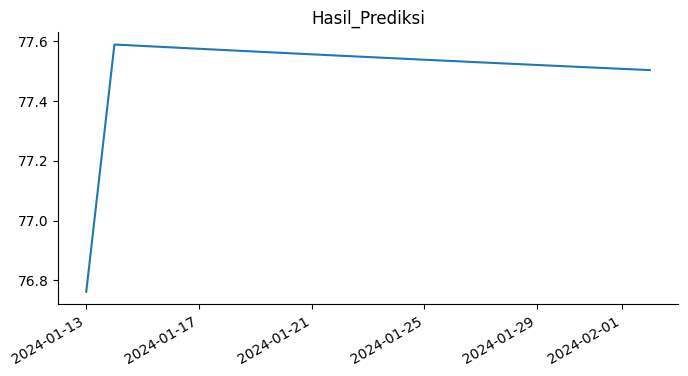

In [53]:
from matplotlib import pyplot as plt
hasil['Hasil_Prediksi'].tail(21).plot(kind='line', figsize=(8, 4), title='Hasil_Prediksi')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Kesimpulan:**

1.   **Model terbaik yang bisa digunakan untuk memprediksi adalah ARIMA (1, 0, 1) dengan error 3.30%**

2.   **Harga Minyak pada awal Februari 2024 diprediksi akan tetap berada pada sekitar 77**

